# Lab Assignment One: Exploring Table Data

CS 5324

2021-02-14

Anthony Wang

## Business Understanding

This dataset contains information about United States on-duty firefighter fatalities that have occurred since January 1, 2000. It is aggregated by the [United States Fire Administration](https://apps.usfa.fema.gov/firefighter-fatalities/) primarily via notification from individual fire departments, but other sources include the U.S. Department of Justice, the National Institute fo Occupational Safety and Health, the Occupational Safety and Health Administration, the U.S. Department of Defense, and the National Interagency Fire Center. This data is collected to find and evaluate methods of reducing firefighter deaths.

This analysis focuses on predicting the nature and cause of death given various combinations of the age, classification, date of incident, date of death, and activity of the firefighter as well as whether the firefighter was on emergency duty. Such information would show how causes of fatalities have changed in more modern times compared to the beginning of the century. The USFA and individual fire departments could identify what conditions have seen reduction in fatalities and sebsequently evaluate the efficacy of solutions to preserve firefighter safety. Alternatively, certain causes of fatalities may be on the rise in recent years, and new solutions could be devised to save firefighter lives.

No prior predictions of this nature could be found, so there exists no precedent which accuracy can be compared to. Therefore, this analysis operates with the belief that a prediction accuracy over 50% for the nature of fatality and cause of fatality would be useful to departments and agencies.

## Data Understanding

In [1]:
import numpy
import pandas
import warnings

warnings.filterwarnings("ignore")

url = "https://apps.usfa.fema.gov/firefighter-fatalities/fatalityData/dataDownload"
dataframe = pandas.read_csv(url, encoding = "cp1252")

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Initial summary     2355 non-null   object 
 1   First name          2355 non-null   object 
 2   Last name           2355 non-null   object 
 3   Middle name         2144 non-null   object 
 4   Age                 1995 non-null   float64
 5   Rank                2348 non-null   object 
 6   Classification      2352 non-null   object 
 7   Incident date       2354 non-null   object 
 8   Date of death       2355 non-null   object 
 9   Cause of death      2342 non-null   object 
 10  Nature of death     2348 non-null   object 
 11  Activity            2338 non-null   object 
 12  Emergency           2355 non-null   object 
 13  Duty                2349 non-null   object 
 14  Property type       2048 non-null   object 
 15  Memorial fund info  787 non-null    object 
dtypes: flo

The summary is difficult to parse meaningfully and incredibly dependent on individual circumstances. The name features are not relevant to the prediction task. The Memorial fund information suffers from the previous problems in addition to having too many null values. Rank appears to be a valuable ordinal feature, but because there is no single standard system of rank in use, there are many unique values which occur very few times. Additionally, due to the many firefighter rank systems, it is difficult to determine whether a rank in one system outranks a rank in another system, making ordinality near impossible to define. For these reasons the mentioned features will be excluded from analysis.

In [2]:
del dataframe["Initial summary"]
del dataframe["First name"]
del dataframe["Last name"]
del dataframe["Middle name"]
del dataframe["Memorial fund info"]

print(len(dataframe["Rank"].unique()))

del dataframe["Rank"]

291


The remaining features need datatype tweaking before use. The dates need conversion from string to datetime and the binary Emergency duty feature would be better suited as a boolean.

In [3]:
dataframe["Incident date"] = pandas.to_datetime(dataframe["Incident date"])
dataframe["Date of death"] = pandas.to_datetime(dataframe["Date of death"])
dataframe.Emergency.replace(to_replace = ["Yes", "No"], value = [True, False], inplace = True)

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Age              1995 non-null   float64       
 1   Classification   2352 non-null   object        
 2   Incident date    2354 non-null   datetime64[ns]
 3   Date of death    2355 non-null   datetime64[ns]
 4   Cause of death   2342 non-null   object        
 5   Nature of death  2348 non-null   object        
 6   Activity         2338 non-null   object        
 7   Emergency        2355 non-null   bool          
 8   Duty             2349 non-null   object        
 9   Property type    2048 non-null   object        
dtypes: bool(1), datetime64[ns](2), float64(1), object(6)
memory usage: 168.0+ KB


A data description table is useful for presenting a general overview of features.

In [4]:
data_descriptor = pandas.DataFrame()
data_descriptor["Features"] = dataframe.columns
data_descriptor["Description"] = [
    "Age of firefighter",
    "Pay or Sector of firefighter",
    "Date of incident which lead to firefighter death",
    "Date of firefighter death",
    "Circumstances which lead to firefighter death",
    "Biological cause at time of death",
    "Responsibility undertaken during incident",
    "Whether incident required emergency response",
    "Status relative to the scene of an alarm",
    "Type of building or land"
]
data_descriptor["Scaling"] = [
    "Ratio",
    "Nominal",
    "Interval",
    "Interval",
    "Nominal",
    "Nominal",
    "Nominal",
    "Nominal",
    "Nominal",
    "Nominal"
]
data_descriptor

Features                                       Description   Scaling
0              Age                                Age of firefighter     Ratio
1   Classification                      Pay or Sector of firefighter   Nominal
2    Incident date  Date of incident which lead to firefighter death  Interval
3    Date of death                         Date of firefighter death  Interval
4   Cause of death     Circumstances which lead to firefighter death   Nominal
5  Nature of death                 Biological cause at time of death   Nominal
6         Activity         Responsibility undertaken during incident   Nominal
7        Emergency      Whether incident required emergency response   Nominal
8             Duty          Status relative to the scene of an alarm   Nominal
9    Property type                          Type of building or land   Nominal

There are duplicated instances in the features. These are unique real-world firefighter fatalities that had circumstances recorded identically by the USFA.

In [5]:
dataframe.duplicated().sum()

344

Many of the features possess null values. For the Age and Property type features, k-nearest-neighbor would be a good choice for imputation because the curation of the USFA ensures data is properly labeled and free of noise. The dataset is also small emough to calculate the nearest neighbors in a timely fashion.

For the other features containing null values, their instances comprise less than 2% of the dataset and can be eliminated without much consequence.

After elimination, this analysis will choose to simply use the dataset as is for plotting and analysis because of its author's lack of expertise in generating a distance function from nominal and datetime features. Unfortunately, this results in losing out on large portions of the dataset when the Age and Property type features are used, which is far from ideal. Should further or future analyses occur outside the scope of this lab, an appropriate distance function and imputation of Age and Property type would be a valuable addition.

In [6]:
columns = list(dataframe.columns)
columns.remove("Age")
columns.remove("Property type")
print(columns)
dataframe.dropna(
    subset = columns,
    inplace = True
)

dataframe.info()

['Classification', 'Incident date', 'Date of death', 'Cause of death', 'Nature of death', 'Activity', 'Emergency', 'Duty']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2354
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Age              1966 non-null   float64       
 1   Classification   2323 non-null   object        
 2   Incident date    2323 non-null   datetime64[ns]
 3   Date of death    2323 non-null   datetime64[ns]
 4   Cause of death   2323 non-null   object        
 5   Nature of death  2323 non-null   object        
 6   Activity         2323 non-null   object        
 7   Emergency        2323 non-null   bool          
 8   Duty             2323 non-null   object        
 9   Property type    2029 non-null   object        
dtypes: bool(1), datetime64[ns](2), float64(1), object(6)
memory usage: 183.8+ KB


## Data Visualization

811
1512


<Figure size 432x288 with 0 Axes>

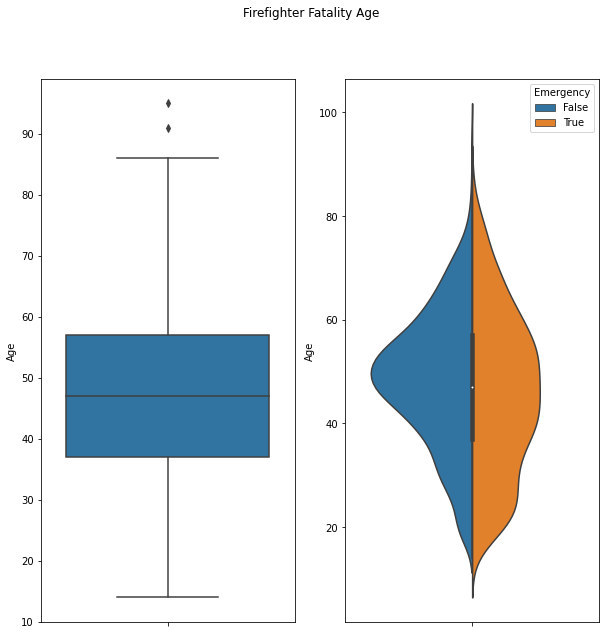

In [7]:
from matplotlib import pyplot
import seaborn

pyplot.figure()
pyplot.subplots(figsize = (10, 10))
pyplot.suptitle("Firefighter Fatality Age")

pyplot.subplot(1,2,1)
seaborn.boxplot(y = "Age", data = dataframe)

#adding a feature which is identical for all objects
dataframe[""] = ""
pyplot.subplot(1,2,2)
seaborn.violinplot(x = "", y = "Age", hue = "Emergency", data = dataframe, split = True)

print(dataframe[dataframe["Emergency"] == False].shape[0])
print(dataframe[dataframe["Emergency"] == True].shape[0])

pyplot.show()

The split violin plot of firefighter fatality ages poses questions about what firefighters are sent to which situations. The immediate implication of the more uniform fatality age distribution for emergency responses is that emergency situations warrant an all-hands-on-deck scenario. Such a scenario would require firefighters to attend the situation regardless of their age, exposing them to the risk of fatality to similar degrees.

But why is there a more peak above the average age for fatalities during non-emergency situations? A possible set of answers includes older firefighters below the age of retirement having greater say in what assignments or calls they take. Seniority could permit them to take shifts that have more house calls than emergencies, and it's during these non-emergencies that they suffer the fatalities plotted.

At first glance it is also peculiar for firefighters to suffer nearly double the fatalities when responding to non-emergencies compared to emergencies. Any further contemplation arrives the thought that non-emergency dispatches must far outnumber emergency dispatches. Depending on what that factor is emergency fatalities being as many as half of non-emergency fatalities could be a testament to the danger associated to emergency dispatches.

<AxesSubplot:title={'center':'Firefighter Fatality Age by Classification'}, xlabel='Classification', ylabel='Age'>

<Figure size 432x288 with 0 Axes>

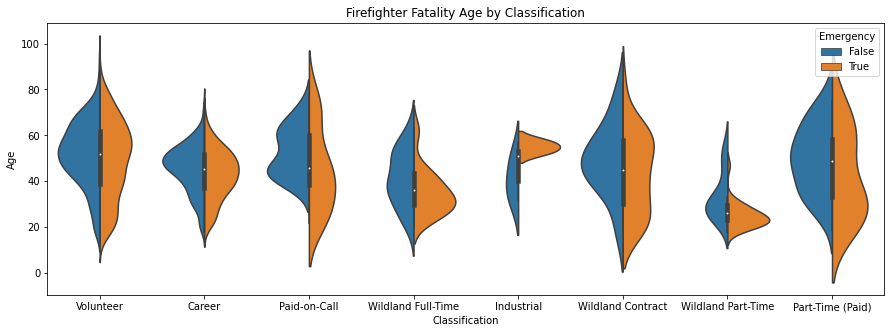

In [8]:
pyplot.figure()
pyplot.subplots(figsize = (15, 5))
pyplot.title("Firefighter Fatality Age by Classification")
seaborn.violinplot(x = "Classification", y = "Age", hue = "Emergency", split = True, data = dataframe)

<AxesSubplot:title={'center':'Firefighter Fatality Age by Duty'}, xlabel='Duty', ylabel='Age'>

<Figure size 432x288 with 0 Axes>

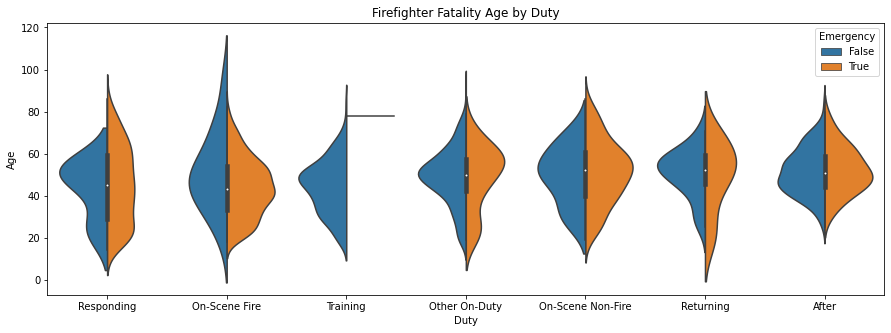

In [9]:
pyplot.figure()
pyplot.subplots(figsize = (15, 5))
pyplot.title("Firefighter Fatality Age by Duty")
seaborn.violinplot(x = "Duty", y = "Age", hue = "Emergency", split = True, data = dataframe)

<AxesSubplot:title={'center':'Firefighter Fatality Count by Activity'}, xlabel='count', ylabel='Activity'>

<Figure size 432x288 with 0 Axes>

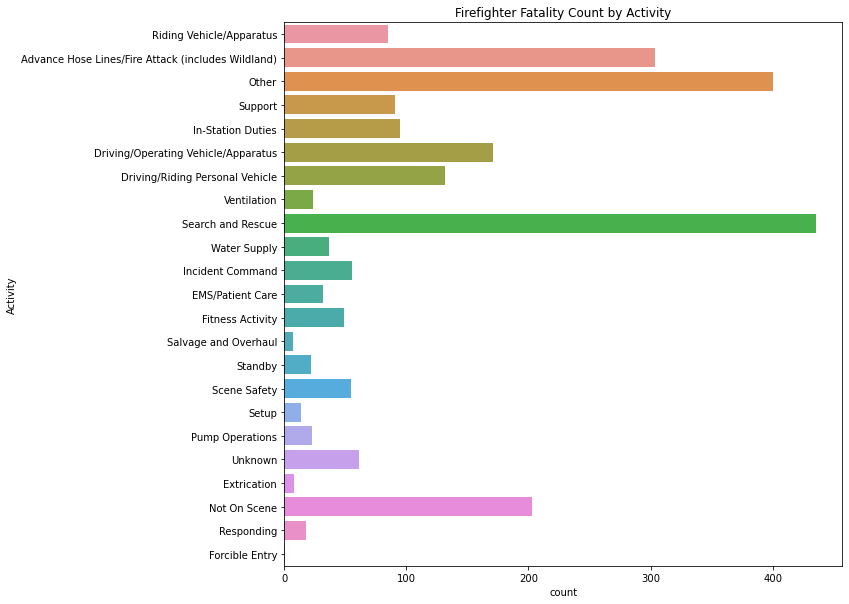

In [10]:
pyplot.figure()
pyplot.subplots(figsize = (10, 10))
pyplot.title("Firefighter Fatality Count by Activity")
seaborn.countplot(y = "Activity", data = dataframe)

(array([  1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   2.,   1.,   2.,   3.,   0.,   0.,   8.,
        106., 442.,  99., 114., 121., 111., 107., 124., 119.,  96.,  89.,
         85.,  84., 109.,  94.,  86.,  87.,  82.,  83.,  63.]),
 array([ 2957.        ,  3321.30952381,  3685.61904762,  4049.92857143,
         4414.23809524,  4778.54761905,  5142.85714286,  5507.16666667,
         5871.47619048,  6235.78571429,  6600.0952381 ,  6964.4047619 ,
         7328.71428571,  7693.02380952,  8057.33333333,  8421.64285714,
         8785.95238095,  9150.26190476,  9514.57142857,  9878.88095238,
        10243.19047619, 10607.5       , 10971.80952381, 11336.11904762,
        11700.42857143, 12064.73809524, 12429.04761905, 12793.35714286,
        13157.66666667, 13521.97619048, 13886.28571429, 14250.5952381 ,
        14614.9047619 , 14979.21428571, 15343.52380952, 15707.83333333,
        16072.14285714, 16436.45238095, 16800.76190476, 17165.0714

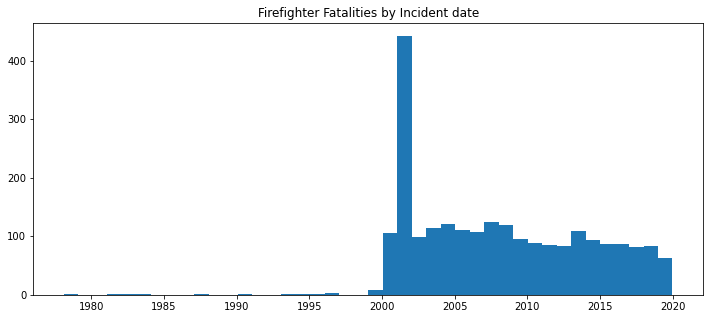

In [11]:
pyplot.figure(figsize = (12, 5))
pyplot.title("Firefighter Fatalities by Incident date")
pyplot.hist(x = "Incident date", bins = 42, data = dataframe)

(array([104., 447.,  97., 116., 117., 118., 110., 119., 118.,  99.,  88.,
         91.,  86., 109.,  94.,  84.,  89.,  87.,  85.,  65.]),
 array([10957. , 11322.1, 11687.2, 12052.3, 12417.4, 12782.5, 13147.6,
        13512.7, 13877.8, 14242.9, 14608. , 14973.1, 15338.2, 15703.3,
        16068.4, 16433.5, 16798.6, 17163.7, 17528.8, 17893.9, 18259. ]),
 <BarContainer object of 20 artists>)

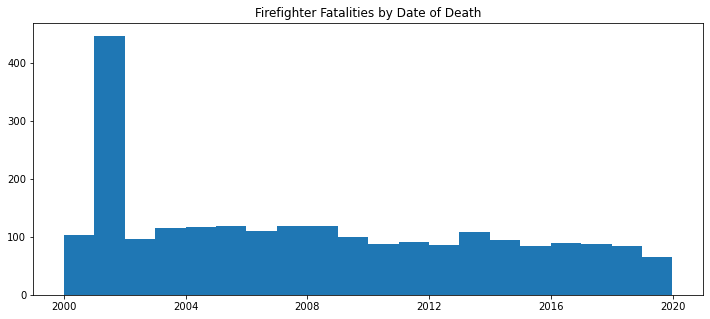

In [12]:
pyplot.figure(figsize = (12, 5))
pyplot.title("Firefighter Fatalities by Date of Death")
pyplot.hist(x = "Date of death", bins = 20, data = dataframe)

The minor dip during 2020 may be attributable to the coronavirus pandemic and subsequent lockdown/quarantine. Reduced human human activity may have resulted in fewer situations warranting dispatches, which in turn results in fewer firefighters entering life-threatening situations.

There is a massive spike in firefighter deaths in the year 2001. This is merely a casual assumption and certainly not intended to be presented as a fact, but the September 11 attacks may be a plausible explanation. If that is the case, then the data points accumulated into the bar are certainly legitimate. But due to the extraordinary circumstances (i.e. the deadliest terrorist attack in human history) that led to the fatalities, should these be analyzed separately from the rest of the fatality data? The 2001 data almost certainly skews whatever trends would be drawn from the dataset as a whole.

The spike prompts a second question in relation to the null age values. There were many unidentified victims in the September 11 attacks, and many of them could have been firefighters. What is the effect of removing the instances containing null age values from the dataset then graphing this same plot? Would the spike be reduced at all? The following plot suggests the answer is yes.

(array([104., 108.,  97., 114., 117., 110., 109., 119., 118.,  98.,  87.,
         86.,  86., 109.,  94.,  84.,  89.,  87.,  85.,  65.]),
 array([10957. , 11322.1, 11687.2, 12052.3, 12417.4, 12782.5, 13147.6,
        13512.7, 13877.8, 14242.9, 14608. , 14973.1, 15338.2, 15703.3,
        16068.4, 16433.5, 16798.6, 17163.7, 17528.8, 17893.9, 18259. ]),
 <BarContainer object of 20 artists>)

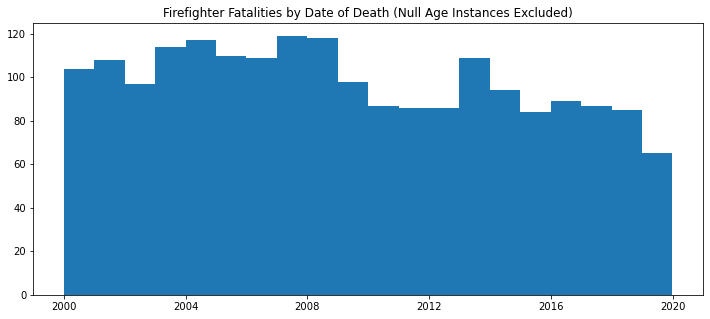

In [13]:
no_null_ages = dataframe.copy(deep = True)
no_null_ages.dropna(subset = ["Age"], inplace = True)
pyplot.figure(figsize = (12, 5))
pyplot.title("Firefighter Fatalities by Date of Death (Null Age Instances Excluded)")
pyplot.hist(x = "Date of death", bins = 20, data = no_null_ages)

Text(0.5, 1.0, 'Firefighter Fatalities by Nature of Death')

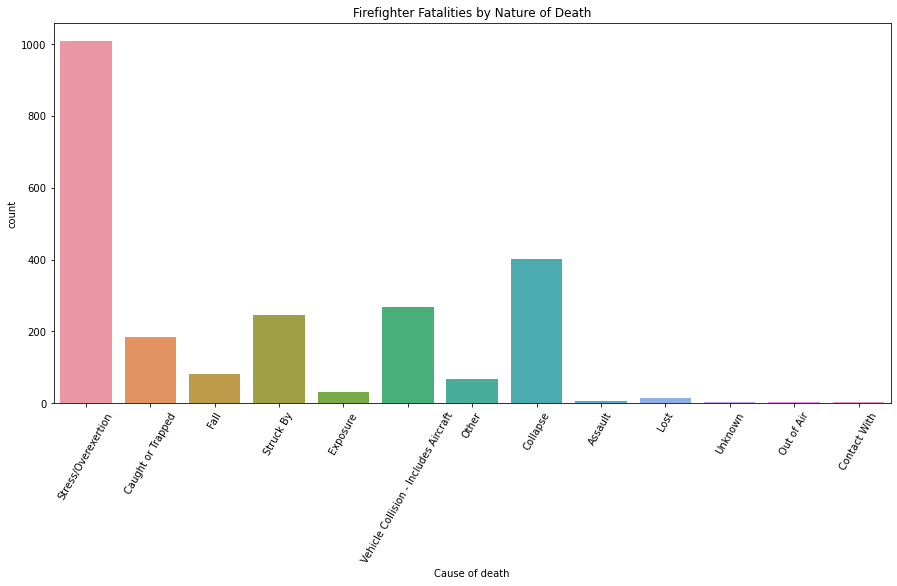

In [14]:
pyplot.figure(figsize = (15, 7))
pyplot.xticks(rotation = 60)
seaborn.countplot(x = "Cause of death", data = dataframe)
pyplot.title("Firefighter Fatalities by Nature of Death")

Text(0.5, 1.0, 'Firefighter Fatalities by Nature of Death')

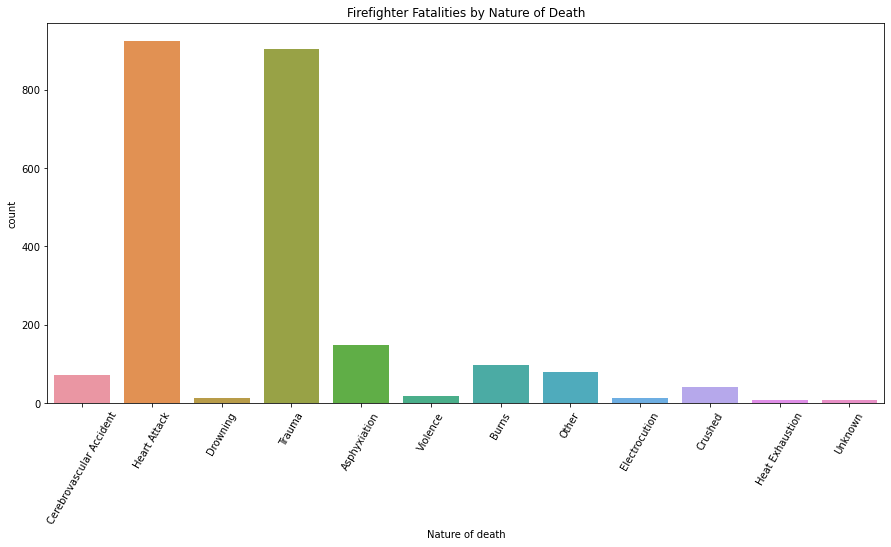

In [15]:
pyplot.figure(figsize = (15, 7))
pyplot.xticks(rotation = 60)
seaborn.countplot(x = "Nature of death", data = dataframe)
pyplot.title("Firefighter Fatalities by Nature of Death")

It was not surprising to see truama far outnumber other natures of firefighter deaths. But it is incredibly surprising to see it still falls short of heart attacks. The large number of heart attack deaths prompted investigation into what the cause may be. The most obvious option is to plot a two-dimensional histogram which counts the number of instances sharing a certain cause of death and nature of death.

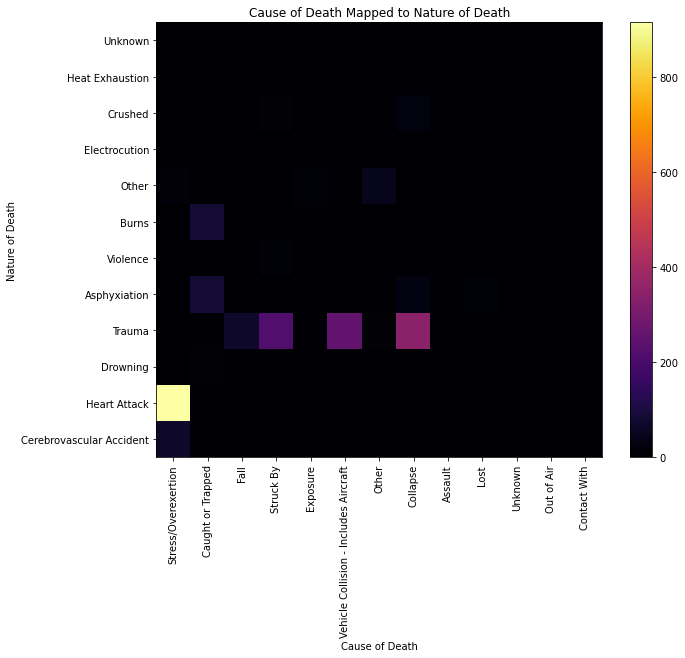

In [16]:
death_dataframe = pandas.DataFrame()
death_dataframe["Nature of death"] = ""
for nature in dataframe["Nature of death"].unique():
    death_dataframe.loc[len(death_dataframe.index)] = nature
for cause in dataframe["Cause of death"].unique():
    death_dataframe[cause] = 0
death_dataframe.set_index("Nature of death", inplace = True)

for index, row in dataframe.iterrows():
    death_dataframe.loc[row["Nature of death"], row["Cause of death"]] += 1

pyplot.figure(figsize = (10, 8))
pyplot.xticks(rotation = 90)
pyplot.pcolor(death_dataframe, cmap = "inferno")
pyplot.colorbar()
pyplot.yticks(numpy.arange(0.5, len(death_dataframe.index), 1), death_dataframe.index)
pyplot.ylabel("Nature of Death")
pyplot.xticks(numpy.arange(0.5, len(death_dataframe.columns), 1), death_dataframe.columns)
pyplot.xlabel("Cause of Death")
pyplot.title("Cause of Death Mapped to Nature of Death")
pyplot.show()

And thus a possible explanation arises. The large number of deaths caused by stress or overexertion frequently results in heart attacks or cerebrovascular accidents (i.e. strokes). This plot also uncovers relations from collapse, collisions, striking, and falls to trauma. Another relation appears between a firefighter being caught or trapped and their death from axphyxiation or burns.

## UMAP Dimensionality Reduction

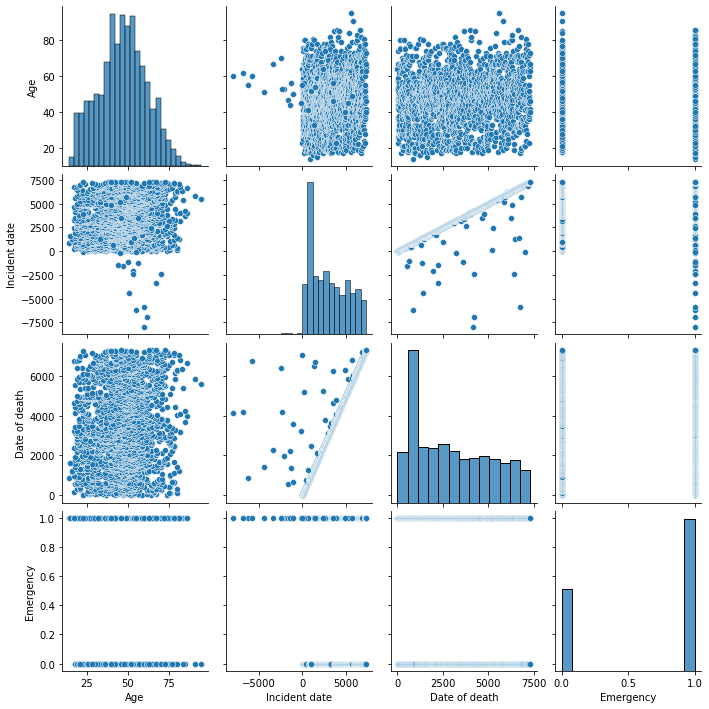

In [17]:
dataframe["Date of death"] = (dataframe["Date of death"] - pandas.to_datetime('2000-01-01')).dt.days
dataframe["Incident date"] = (dataframe["Incident date"] - pandas.to_datetime('2000-01-01')).dt.days

seaborn.pairplot(dataframe)

In [23]:
import umap

# required in order to use umap.plot
%pip install datashader -q
%pip install bokeh -q
%pip install holoviews -q
%pip install colorcet -q

import umap.plot

dataframe.dropna(inplace = True)
relevant_features = [
    "Age",
    "Incident date",
    "Date of death",
    "Emergency"
]
dataframe_relevant = dataframe[relevant_features]

# much of the following code takes heavy inspiration from the UMAP git repository and uses their recommended values
embedding = umap.UMAP(n_neighbors = 5).fit(dataframe_relevant)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [37]:
# The follwing line takes heavy inspiration from the UMAP documentation
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
embedding = umap.UMAP(n_neighbors = 10, min_dist = 0.1).fit(dataframe_relevant)

<AxesSubplot:>

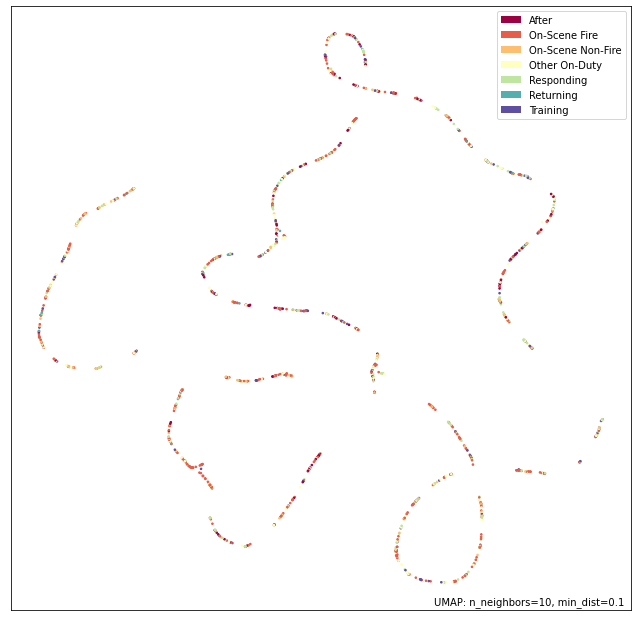

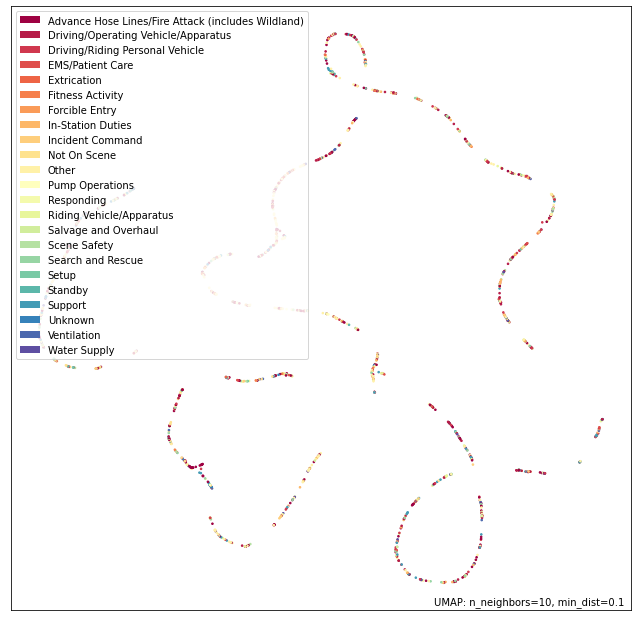

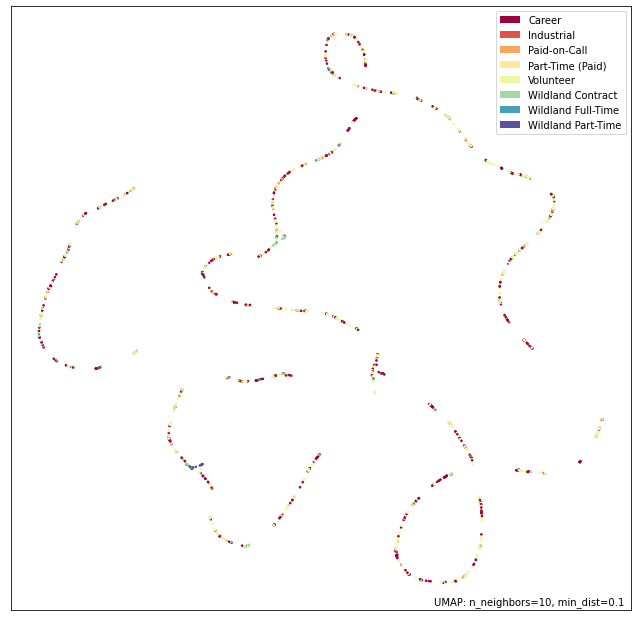

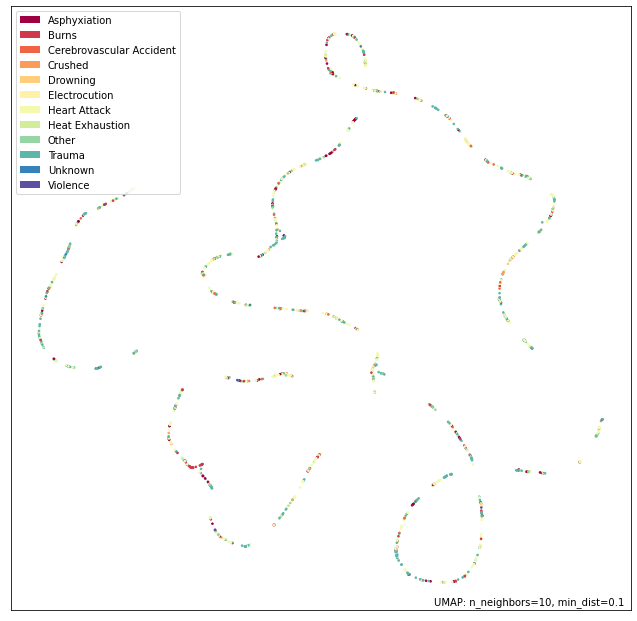

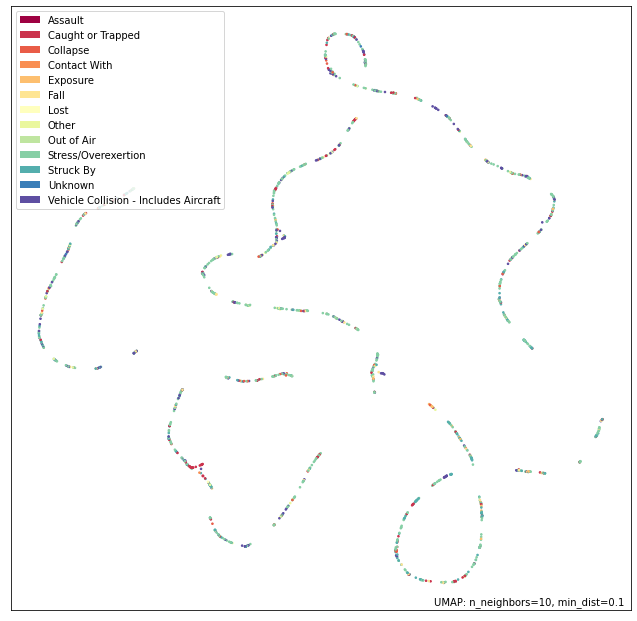

In [38]:
umap.plot.points(embedding, labels = dataframe["Duty"])
umap.plot.points(embedding, labels = dataframe["Activity"])
umap.plot.points(embedding, labels = dataframe["Classification"])
umap.plot.points(embedding, labels = dataframe["Nature of death"])
umap.plot.points(embedding, labels = dataframe["Cause of death"])

None of the UMAP reduced plots contain identifiable clusters of the same target value. This implies it is difficult to reduce the dimensionality between the four fitted features without unrecognizeably changing qualities of the raw data. No amount of tweaking of the n_neighbors and min_dist parameters proved fruitful. Such an outcome is likely due to the lack of relation both within the features which were fitted and between the features and targets. There is little to be analytically gained from a UMAP dimensionality reduction.